In [1]:
# General imports
import os
import sys
import numpy as np
import tensorflow as tf
import gc
import optuna

# Sklearn imports
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Keras imports
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import neural_network_functions as neural_net_fun
import general_functions as gf

c:\Users\Orlando Mota Pires\miniconda3\envs\t3-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if TensorFlow can find the GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("TensorFlow found the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

TensorFlow found the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
def objective(trial, timesteps, num_classes, num_features, X_balanced_normalized, Y_balanced, batch_size):
    conv_filters = trial.suggest_int('conv_filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    lstm_units = trial.suggest_int('lstm_units', 20, 150)
    dropout_conv = trial.suggest_float('dropout_conv', 0.2, 0.5)
    dropout_lstm = trial.suggest_float('dropout_lstm', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 5)
    kernel_regularizer_l1 = trial.suggest_loguniform('kernel_regularizer_l1', 1e-6, 1e-2)
    kernel_regularizer_l2 = trial.suggest_loguniform('kernel_regularizer_l2', 1e-10, 1e-3)

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store scores
    scores = []

    for train_index, val_index in kf.split(X_balanced_normalized):
        X_train_fold, X_val = X_balanced_normalized[train_index], X_balanced_normalized[val_index]
        y_train_fold, Y_val = Y_balanced[train_index], Y_balanced[val_index]

        # Create the model
        model = neural_net_fun.define_model(
            timesteps, 
            num_features, 
            num_classes, 
            conv_filters, 
            kernel_size, 
            lstm_units, 
            dropout_conv, 
            dropout_lstm, 
            learning_rate, 
            kernel_regularizer_l1,
            kernel_regularizer_l2
        )
        
        # Early stopping and learning rate reduction callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=int(10/2), min_lr=1e-6)

        # Convert Y_train and Y_val to one-hot encoding
        y_train_fold = to_categorical(y_train_fold, num_classes)
        Y_val = to_categorical(Y_val, num_classes)

        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=batch_size, verbose=0, validation_data=(X_val, Y_val), callbacks=[early_stopping, lr_scheduler])
        
        # Evaluate the model
        y_pred = model.predict(X_val)
        y_pred = np.round(y_pred)
        
        # Calculate accuracy for this fold
        accuracy = accuracy_score(Y_val, y_pred)
        scores.append(accuracy)

        # Clear memory and collect garbage
        del model, X_train_fold, X_val, y_train_fold, Y_val, y_pred
        gc.collect()

    # Calculate average score
    avg_score = np.mean(scores)
    
    return avg_score


## Listing all available datasets

In [4]:
dataset_list = gf.find_files_in_all_subdirectories([os.path.join('.', 'result_sequences')], '*.CSV')
print("Datasets available: ", dataset_list)

Datasets available:  ['.\\result_sequences\\DATASET_SEQUENCES_2.CSV', '.\\result_sequences\\DATASET_SEQUENCES_6.CSV']


## Selecting the dataset

In [5]:
SEQUENCES_NAME_FILE = dataset_list[0]

## Pre process the data 

In [6]:
data_info = neural_net_fun.preprocess_data_current_dataset(SEQUENCES_NAME_FILE, emotions = "label == 'happy' | label == 'neutral'")

batch_size = 256

label_mapping = data_info['label_mapping']
timesteps = data_info['timesteps']
n_classes = data_info['n_classes']
n_features = data_info['n_features']

X_before_balancing = data_info['X_before_balancing']
Y_before_balancing = data_info['Y_before_balancing']

X_complete = data_info['X_complete']
Y_complete = data_info['Y_complete']

X_train = data_info['X_train']
X_val = data_info['X_val']
X_test = data_info['X_test']

Y_train = data_info['Y_train']
Y_val = data_info['Y_val']
Y_test = data_info['Y_test']

print(f"Number of neutral samples: {list(Y_complete).count(1)}")
print(f"Number of happy samples: {list(Y_complete).count(0)}")

Label Mapping: {'happy': 0, 'neutral': 1}
Features being used: ['m1', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'e1', 'e2', 'e3', 'b1', 'b2', 'b3']
Number of neutral samples: 1488
Number of happy samples: 1488


## Checking the data

In [7]:
neural_net_fun.show_data_comparison(label_mapping, X_before_balancing, Y_before_balancing, X_complete, Y_complete)

===== Label Mapping =====
'happy' -> 0
'neutral' -> 1

===== Data Before Balancing =====
Shape of X_before_balancing: (3704, 126, 22)
Shape of Y_before_balancing: (3704,)
Sample count per class (before balancing):
Class 'happy' (Value 0): 1488 samples
Class 'neutral' (Value 1): 2216 samples

===== Data After Balancing =====
Shape of X_balanced_normalized: (2976, 126, 22)
Shape of Y_balanced: (2976,)
Sample count per class (after balancing):
Class 'happy' (Value 0): 1488 samples
Class 'neutral' (Value 1): 1488 samples


In [8]:
neural_net_fun.checking_data(label_mapping, timesteps, n_classes, n_features, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test)

===== Data Information =====
Timesteps: 126
Number of classes: 2
Number of features: 22

===== Label Mapping =====
'happy' -> 0
'neutral' -> 1

===== Balanced and Normalized Data =====
Shape of X_balanced_normalized: (2976, 126, 22)
Shape of Y_balanced: (2976,)

===== Training Set =====
Shape of X_train: (2082, 126, 22)
Shape of y_train: (2082, 1)

===== Validation Set =====
Shape of X_val: (447, 126, 22)
Shape of y_val: (447, 1)

===== Test Set =====
Shape of X_test: (447, 126, 22)
Shape of y_test: (447, 1)

===== Training Set Statistics =====
Class 'happy' (Value 0): 1041 samples
Class 'neutral' (Value 1): 1041 samples

===== Validation Set Statistics =====
Class 'happy' (Value 0): 223 samples
Class 'neutral' (Value 1): 224 samples

===== Test Set Statistics =====
Class 'happy' (Value 0): 224 samples
Class 'neutral' (Value 1): 223 samples


## Tunning the model

In [9]:
# Getting the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, timesteps, n_classes, n_features, X_complete, Y_complete, batch_size), n_trials=50)
print("Best params found:", study.best_params)

[I 2024-10-24 13:59:34,265] A new study created in memory with name: no-name-2295c4ad-71a4-42ef-a504-409d7173a421


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:00:21,940] Trial 0 finished with value: 0.6834639896226947 and parameters: {'conv_filters': 18, 'kernel_size': 4, 'lstm_units': 56, 'dropout_conv': 0.48116065178941847, 'dropout_lstm': 0.3742691931822987, 'learning_rate': 0.0005940070604443831, 'kernel_regularizer_l1': 7.848593257294317e-06, 'kernel_regularizer_l2': 1.176061214401894e-06}. Best is trial 0 with value: 0.6834639896226947.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:00:46,970] Trial 1 finished with value: 0.5161429135412554 and parameters: {'conv_filters': 29, 'kernel_size': 2, 'lstm_units': 65, 'dropout_conv': 0.40721810557677734, 'dropout_lstm': 0.2726617829137289, 'learning_rate': 1.651278669846147e-05, 'kernel_regularizer_l1': 1.0629952895275916e-05, 'kernel_regularizer_l2': 1.594008612963134e-08}. Best is trial 0 with value: 0.6834639896226947.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:01:10,033] Trial 2 finished with value: 0.4889222266087643 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'lstm_units': 148, 'dropout_conv': 0.43384957073680175, 'dropout_lstm': 0.41091397212170844, 'learning_rate': 2.5858576144391583e-08, 'kernel_regularizer_l1': 3.5788108674031244e-05, 'kernel_regularizer_l2': 8.631899370250268e-05}. Best is trial 0 with value: 0.6834639896226947.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:01:30,928] Trial 3 finished with value: 0.5120991483841859 and parameters: {'conv_filters': 57, 'kernel_size': 4, 'lstm_units': 44, 'dropout_conv': 0.21535348882451422, 'dropout_lstm': 0.2592583628931672, 'learning_rate': 7.578800991503839e-08, 'kernel_regularizer_l1': 0.00033933329807875866, 'kernel_regularizer_l2': 2.212629390985342e-07}. Best is trial 0 with value: 0.6834639896226947.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:02:08,871] Trial 4 finished with value: 0.7073859342394676 and parameters: {'conv_filters': 53, 'kernel_size': 3, 'lstm_units': 63, 'dropout_conv': 0.279178756759612, 'dropout_lstm': 0.3734744546500104, 'learning_rate': 0.016457888404892415, 'kernel_regularizer_l1': 4.352447961134755e-06, 'kernel_regularizer_l2': 1.3699107773018404e-07}. Best is trial 4 with value: 0.7073859342394676.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:02:33,960] Trial 5 finished with value: 0.5252010602898877 and parameters: {'conv_filters': 22, 'kernel_size': 5, 'lstm_units': 81, 'dropout_conv': 0.4080301587573596, 'dropout_lstm': 0.2278689550070373, 'learning_rate': 5.90678255951537e-07, 'kernel_regularizer_l1': 0.0001343205512745419, 'kernel_regularizer_l2': 3.818804624127065e-09}. Best is trial 4 with value: 0.7073859342394676.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:03:23,913] Trial 6 finished with value: 0.7496672494501156 and parameters: {'conv_filters': 43, 'kernel_size': 3, 'lstm_units': 115, 'dropout_conv': 0.39036738250840436, 'dropout_lstm': 0.20946053404607112, 'learning_rate': 0.008989232460542186, 'kernel_regularizer_l1': 1.7105675146021185e-06, 'kernel_regularizer_l2': 1.5586773640184715e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:03:46,166] Trial 7 finished with value: 0.5090846539958266 and parameters: {'conv_filters': 47, 'kernel_size': 5, 'lstm_units': 34, 'dropout_conv': 0.39207734677226247, 'dropout_lstm': 0.21864763971556356, 'learning_rate': 5.159377603121822e-08, 'kernel_regularizer_l1': 1.4081663208517482e-05, 'kernel_regularizer_l2': 0.0006487539366311625}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:04:08,865] Trial 8 finished with value: 0.5211663188765439 and parameters: {'conv_filters': 49, 'kernel_size': 5, 'lstm_units': 68, 'dropout_conv': 0.38178888229896824, 'dropout_lstm': 0.4877359327892397, 'learning_rate': 2.0189920523482686e-06, 'kernel_regularizer_l1': 0.0021372145992293815, 'kernel_regularizer_l2': 1.8910337003007181e-06}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:04:36,600] Trial 9 finished with value: 0.5625164965314985 and parameters: {'conv_filters': 61, 'kernel_size': 2, 'lstm_units': 124, 'dropout_conv': 0.4505558792746469, 'dropout_lstm': 0.4240699316598693, 'learning_rate': 0.0014088063948697147, 'kernel_regularizer_l1': 0.0006849574954143364, 'kernel_regularizer_l2': 2.932025599888668e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:05:20,430] Trial 10 finished with value: 0.5319254413174666 and parameters: {'conv_filters': 37, 'kernel_size': 3, 'lstm_units': 111, 'dropout_conv': 0.32908139751369, 'dropout_lstm': 0.31720172843182515, 'learning_rate': 2.7896553463659157, 'kernel_regularizer_l1': 1.115132277655988e-06, 'kernel_regularizer_l2': 1.227114418744513e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:05:42,690] Trial 11 finished with value: 0.5117359426992273 and parameters: {'conv_filters': 43, 'kernel_size': 3, 'lstm_units': 105, 'dropout_conv': 0.2930591668196973, 'dropout_lstm': 0.33351059917646775, 'learning_rate': 0.08579000206002338, 'kernel_regularizer_l1': 1.0062931250944577e-06, 'kernel_regularizer_l2': 2.1068276065583348e-08}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:06:29,033] Trial 12 finished with value: 0.7385753764593086 and parameters: {'conv_filters': 54, 'kernel_size': 3, 'lstm_units': 94, 'dropout_conv': 0.25857196050787495, 'dropout_lstm': 0.29633016537878726, 'learning_rate': 0.010045219787694265, 'kernel_regularizer_l1': 3.551621537064603e-06, 'kernel_regularizer_l2': 1.1786193128013038e-05}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:06:51,319] Trial 13 finished with value: 0.5040245897016524 and parameters: {'conv_filters': 37, 'kernel_size': 2, 'lstm_units': 97, 'dropout_conv': 0.213713698247173, 'dropout_lstm': 0.20034649617088074, 'learning_rate': 0.0794081390410794, 'kernel_regularizer_l1': 2.9177770595868216e-06, 'kernel_regularizer_l2': 2.3781758815916492e-05}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:07:42,953] Trial 14 finished with value: 0.48521854379335627 and parameters: {'conv_filters': 62, 'kernel_size': 4, 'lstm_units': 127, 'dropout_conv': 0.3315259383820383, 'dropout_lstm': 0.290464738553064, 'learning_rate': 2.1412743090898867, 'kernel_regularizer_l1': 3.6460835872312324e-05, 'kernel_regularizer_l2': 1.2680386023645492e-05}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:08:27,416] Trial 15 finished with value: 0.7473109243697479 and parameters: {'conv_filters': 42, 'kernel_size': 3, 'lstm_units': 88, 'dropout_conv': 0.26368720694697523, 'dropout_lstm': 0.256181847283315, 'learning_rate': 0.008208485040570191, 'kernel_regularizer_l1': 2.552081016120801e-06, 'kernel_regularizer_l2': 1.3147075197276756e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:09:18,777] Trial 16 finished with value: 0.6337409057582765 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'lstm_units': 146, 'dropout_conv': 0.35869424356279184, 'dropout_lstm': 0.24315905661916204, 'learning_rate': 6.613926045129746e-05, 'kernel_regularizer_l1': 0.005185919864963701, 'kernel_regularizer_l2': 1.1700869785269508e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:09:40,805] Trial 17 finished with value: 0.56286052676104 and parameters: {'conv_filters': 43, 'kernel_size': 2, 'lstm_units': 80, 'dropout_conv': 0.30880721038673287, 'dropout_lstm': 0.25779135244799645, 'learning_rate': 0.0045220529889692315, 'kernel_regularizer_l1': 3.2963809621762775e-05, 'kernel_regularizer_l2': 1.311799873701094e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:10:07,883] Trial 18 finished with value: 0.5346128249957701 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'lstm_units': 122, 'dropout_conv': 0.24794753926538415, 'dropout_lstm': 0.2248033514413808, 'learning_rate': 0.12848614898669863, 'kernel_regularizer_l1': 2.1899230182139176e-06, 'kernel_regularizer_l2': 1.7626705504092145e-08}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:10:31,320] Trial 19 finished with value: 0.4966476792059106 and parameters: {'conv_filters': 47, 'kernel_size': 4, 'lstm_units': 113, 'dropout_conv': 0.35975730394606753, 'dropout_lstm': 0.20469245687093454, 'learning_rate': 0.0001194241028176401, 'kernel_regularizer_l1': 1.8297603120288776e-05, 'kernel_regularizer_l2': 3.347912972652589e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:11:12,810] Trial 20 finished with value: 0.5285556370199087 and parameters: {'conv_filters': 26, 'kernel_size': 2, 'lstm_units': 135, 'dropout_conv': 0.49927980221528845, 'dropout_lstm': 0.3004553486811642, 'learning_rate': 0.6762891809339944, 'kernel_regularizer_l1': 9.046013936097146e-05, 'kernel_regularizer_l2': 2.3806001888727018e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:12:03,829] Trial 21 finished with value: 0.7426129377925668 and parameters: {'conv_filters': 53, 'kernel_size': 3, 'lstm_units': 85, 'dropout_conv': 0.27734517409018467, 'dropout_lstm': 0.2759983861207519, 'learning_rate': 0.010169987082321724, 'kernel_regularizer_l1': 3.3728805330553027e-06, 'kernel_regularizer_l2': 1.0781237545844111e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:12:27,055] Trial 22 finished with value: 0.5578044103547459 and parameters: {'conv_filters': 42, 'kernel_size': 3, 'lstm_units': 95, 'dropout_conv': 0.2692419284193441, 'dropout_lstm': 0.2709490637190107, 'learning_rate': 0.002587213859400912, 'kernel_regularizer_l1': 6.229329317478878e-06, 'kernel_regularizer_l2': 1.0332100672009422e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:13:15,197] Trial 23 finished with value: 0.7442862782696972 and parameters: {'conv_filters': 50, 'kernel_size': 3, 'lstm_units': 83, 'dropout_conv': 0.24065185909149195, 'dropout_lstm': 0.24198171550449762, 'learning_rate': 0.020357330661845727, 'kernel_regularizer_l1': 1.6894653255909308e-06, 'kernel_regularizer_l2': 5.219670322856663e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:13:50,101] Trial 24 finished with value: 0.5564249055326829 and parameters: {'conv_filters': 37, 'kernel_size': 3, 'lstm_units': 103, 'dropout_conv': 0.2359442573018918, 'dropout_lstm': 0.2437496187972383, 'learning_rate': 0.0005372744409895542, 'kernel_regularizer_l1': 1.6307141586426e-06, 'kernel_regularizer_l2': 6.491491038142087e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:14:30,128] Trial 25 finished with value: 0.6898437764367491 and parameters: {'conv_filters': 49, 'kernel_size': 4, 'lstm_units': 78, 'dropout_conv': 0.311367347322805, 'dropout_lstm': 0.24295398157580522, 'learning_rate': 0.034763925504145775, 'kernel_regularizer_l1': 2.071943626013037e-06, 'kernel_regularizer_l2': 5.930199035143458e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:14:51,616] Trial 26 finished with value: 0.4902430770966105 and parameters: {'conv_filters': 39, 'kernel_size': 3, 'lstm_units': 47, 'dropout_conv': 0.20492256306796225, 'dropout_lstm': 0.33211185359913703, 'learning_rate': 0.6806299325467637, 'kernel_regularizer_l1': 6.898660236071778e-06, 'kernel_regularizer_l2': 4.100040882080031e-08}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 5ms/step


[I 2024-10-24 14:15:21,884] Trial 27 finished with value: 0.5013338221194518 and parameters: {'conv_filters': 45, 'kernel_size': 2, 'lstm_units': 116, 'dropout_conv': 0.34218276101421397, 'dropout_lstm': 0.22184046609949187, 'learning_rate': 0.2878137264160015, 'kernel_regularizer_l1': 1.1312345448050644e-06, 'kernel_regularizer_l2': 6.161876579271654e-10}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:15:49,799] Trial 28 finished with value: 0.524174045457109 and parameters: {'conv_filters': 57, 'kernel_size': 3, 'lstm_units': 74, 'dropout_conv': 0.2359027294296728, 'dropout_lstm': 0.489877805292086, 'learning_rate': 2.0504349237228098e-05, 'kernel_regularizer_l1': 1.7791747855261408e-05, 'kernel_regularizer_l2': 6.457540263297807e-09}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:16:09,805] Trial 29 finished with value: 0.5050510405504485 and parameters: {'conv_filters': 33, 'kernel_size': 4, 'lstm_units': 23, 'dropout_conv': 0.4352728000516359, 'dropout_lstm': 0.35873934384299416, 'learning_rate': 0.0004453570276391513, 'kernel_regularizer_l1': 5.864155547234275e-06, 'kernel_regularizer_l2': 9.774232032842043e-07}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:16:42,247] Trial 30 finished with value: 0.6189656533754442 and parameters: {'conv_filters': 40, 'kernel_size': 4, 'lstm_units': 90, 'dropout_conv': 0.46239356031491696, 'dropout_lstm': 0.31301779947138436, 'learning_rate': 0.0019189510869845679, 'kernel_regularizer_l1': 2.274986111328231e-06, 'kernel_regularizer_l2': 5.0950237060689145e-08}. Best is trial 6 with value: 0.7496672494501156.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:17:30,880] Trial 31 finished with value: 0.7513496136709717 and parameters: {'conv_filters': 50, 'kernel_size': 3, 'lstm_units': 89, 'dropout_conv': 0.28554521933561844, 'dropout_lstm': 0.2748926670190172, 'learning_rate': 0.012791888438079074, 'kernel_regularizer_l1': 3.4084510625196977e-06, 'kernel_regularizer_l2': 2.0458597045211593e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:18:14,289] Trial 32 finished with value: 0.688503186509503 and parameters: {'conv_filters': 50, 'kernel_size': 3, 'lstm_units': 103, 'dropout_conv': 0.23620656651827449, 'dropout_lstm': 0.2463687295492661, 'learning_rate': 0.018599924725234578, 'kernel_regularizer_l1': 9.420210011913899e-06, 'kernel_regularizer_l2': 3.658329366487567e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:18:37,275] Trial 33 finished with value: 0.49696576617224075 and parameters: {'conv_filters': 45, 'kernel_size': 3, 'lstm_units': 60, 'dropout_conv': 0.2985600367055288, 'dropout_lstm': 0.27951213805011155, 'learning_rate': 0.04900980138275374, 'kernel_regularizer_l1': 1.67076080043108e-06, 'kernel_regularizer_l2': 1.3009656752710633e-09}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:19:22,829] Trial 34 finished with value: 0.6767322768033388 and parameters: {'conv_filters': 51, 'kernel_size': 3, 'lstm_units': 71, 'dropout_conv': 0.2512455434663241, 'dropout_lstm': 0.2551081449415558, 'learning_rate': 0.005321293747216401, 'kernel_regularizer_l1': 4.36544894928227e-06, 'kernel_regularizer_l2': 3.101502739920667e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:19:51,953] Trial 35 finished with value: 0.5779470983024082 and parameters: {'conv_filters': 58, 'kernel_size': 2, 'lstm_units': 88, 'dropout_conv': 0.37408866265862534, 'dropout_lstm': 0.41539051799258564, 'learning_rate': 0.0009854413794969643, 'kernel_regularizer_l1': 1.0208568391170708e-05, 'kernel_regularizer_l2': 3.5159430712047033e-09}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:20:20,340] Trial 36 finished with value: 0.542988551125148 and parameters: {'conv_filters': 56, 'kernel_size': 3, 'lstm_units': 49, 'dropout_conv': 0.41147598174174743, 'dropout_lstm': 0.212742764375894, 'learning_rate': 0.00021610807089147142, 'kernel_regularizer_l1': 2.74198755225367e-05, 'kernel_regularizer_l2': 9.337387738957175e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:21:06,604] Trial 37 finished with value: 0.700267892391856 and parameters: {'conv_filters': 46, 'kernel_size': 3, 'lstm_units': 140, 'dropout_conv': 0.2684549875948682, 'dropout_lstm': 0.23235872256589432, 'learning_rate': 0.015021078465332283, 'kernel_regularizer_l1': 0.00013628771681904996, 'kernel_regularizer_l2': 2.060239099126788e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:21:43,416] Trial 38 finished with value: 0.4999909762562743 and parameters: {'conv_filters': 52, 'kernel_size': 2, 'lstm_units': 56, 'dropout_conv': 0.22588612527223093, 'dropout_lstm': 0.3939934277386039, 'learning_rate': 0.2693959980079794, 'kernel_regularizer_l1': 6.235073817093742e-05, 'kernel_regularizer_l2': 9.220822668039927e-09}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:22:09,693] Trial 39 finished with value: 0.5215216287857425 and parameters: {'conv_filters': 41, 'kernel_size': 4, 'lstm_units': 65, 'dropout_conv': 0.2816002163169388, 'dropout_lstm': 0.2762875316048203, 'learning_rate': 3.4149795336497603e-05, 'kernel_regularizer_l1': 0.0003113569880364241, 'kernel_regularizer_l2': 1.7906889820687325e-09}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:22:34,185] Trial 40 finished with value: 0.5046940386893012 and parameters: {'conv_filters': 19, 'kernel_size': 3, 'lstm_units': 84, 'dropout_conv': 0.32898766812330305, 'dropout_lstm': 0.45202307736179387, 'learning_rate': 1.4113976764531065e-06, 'kernel_regularizer_l1': 4.7608028960527114e-06, 'kernel_regularizer_l2': 1.193658200436117e-07}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:23:09,758] Trial 41 finished with value: 0.6263758389261744 and parameters: {'conv_filters': 54, 'kernel_size': 3, 'lstm_units': 88, 'dropout_conv': 0.2817790987216848, 'dropout_lstm': 0.2655002129513911, 'learning_rate': 0.005811257980272347, 'kernel_regularizer_l1': 3.431876416947484e-06, 'kernel_regularizer_l2': 1.6044397456643482e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:23:54,240] Trial 42 finished with value: 0.691869606903164 and parameters: {'conv_filters': 59, 'kernel_size': 3, 'lstm_units': 74, 'dropout_conv': 0.2687744626462391, 'dropout_lstm': 0.2815560987699936, 'learning_rate': 0.024190406556370343, 'kernel_regularizer_l1': 1.5995851646179972e-06, 'kernel_regularizer_l2': 5.46051488446225e-10}. Best is trial 31 with value: 0.7513496136709717.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:24:49,121] Trial 43 finished with value: 0.7557120297783543 and parameters: {'conv_filters': 49, 'kernel_size': 3, 'lstm_units': 101, 'dropout_conv': 0.2932449880218827, 'dropout_lstm': 0.23172824252176266, 'learning_rate': 0.0093847954371503, 'kernel_regularizer_l1': 2.83945680079123e-06, 'kernel_regularizer_l2': 1.1813309120593746e-10}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:25:14,850] Trial 44 finished with value: 0.55644802887598 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'lstm_units': 109, 'dropout_conv': 0.31232199455013054, 'dropout_lstm': 0.23217984725624116, 'learning_rate': 0.0026964195809202284, 'kernel_regularizer_l1': 1.1796675876268397e-06, 'kernel_regularizer_l2': 2.5465597503694006e-10}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:25:47,796] Trial 45 finished with value: 0.5046968586092155 and parameters: {'conv_filters': 44, 'kernel_size': 3, 'lstm_units': 99, 'dropout_conv': 0.29221583128358514, 'dropout_lstm': 0.2125954680163224, 'learning_rate': 0.15581904204632663, 'kernel_regularizer_l1': 2.767909810563155e-06, 'kernel_regularizer_l2': 0.0009540708543751248}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 1s 5ms/step


[I 2024-10-24 14:26:20,284] Trial 46 finished with value: 0.5820032711071006 and parameters: {'conv_filters': 49, 'kernel_size': 3, 'lstm_units': 117, 'dropout_conv': 0.4107318122661132, 'dropout_lstm': 0.20087752430795822, 'learning_rate': 0.0009831045775384392, 'kernel_regularizer_l1': 8.276357365198645e-06, 'kernel_regularizer_l2': 2.8593610896738733e-09}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 0s 3ms/step


[I 2024-10-24 14:26:51,961] Trial 47 finished with value: 0.4999909762562743 and parameters: {'conv_filters': 39, 'kernel_size': 5, 'lstm_units': 95, 'dropout_conv': 0.25832103634093717, 'dropout_lstm': 0.2573186775729202, 'learning_rate': 0.0458079479996704, 'kernel_regularizer_l1': 1.2240621270472708e-05, 'kernel_regularizer_l2': 0.00023727134276324983}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:27:37,646] Trial 48 finished with value: 0.5198240369973492 and parameters: {'conv_filters': 34, 'kernel_size': 2, 'lstm_units': 106, 'dropout_conv': 0.3926582269725069, 'dropout_lstm': 0.2330102932785832, 'learning_rate': 4.971972279353545, 'kernel_regularizer_l1': 1.0188219401678549e-06, 'kernel_regularizer_l2': 6.747349931613425e-10}. Best is trial 43 with value: 0.7557120297783543.


19/19 [==============================] - 0s 4ms/step


[I 2024-10-24 14:28:10,104] Trial 49 finished with value: 0.5773019006260223 and parameters: {'conv_filters': 47, 'kernel_size': 4, 'lstm_units': 128, 'dropout_conv': 0.2230771520596754, 'dropout_lstm': 0.30499639084397967, 'learning_rate': 0.00888829122078225, 'kernel_regularizer_l1': 0.001004764176723564, 'kernel_regularizer_l2': 1.9979762750973067e-10}. Best is trial 43 with value: 0.7557120297783543.


Best params found: {'conv_filters': 49, 'kernel_size': 3, 'lstm_units': 101, 'dropout_conv': 0.2932449880218827, 'dropout_lstm': 0.23172824252176266, 'learning_rate': 0.0093847954371503, 'kernel_regularizer_l1': 2.83945680079123e-06, 'kernel_regularizer_l2': 1.1813309120593746e-10}


## Training the model

Epoch 1/100
9/9 [==============================] - 2s 72ms/step - loss: 0.9272 - accuracy: 0.5197 - val_loss: 0.7221 - val_accuracy: 0.4989
Epoch 2/100
9/9 [==============================] - 0s 23ms/step - loss: 0.7061 - accuracy: 0.5682 - val_loss: 0.7232 - val_accuracy: 0.4989
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.6225 - accuracy: 0.6057 - val_loss: 0.7265 - val_accuracy: 0.4989
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.5750 - accuracy: 0.6431 - val_loss: 0.7236 - val_accuracy: 0.4989
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.5378 - accuracy: 0.6844 - val_loss: 0.7274 - val_accuracy: 0.5414
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.5129 - accuracy: 0.6960 - val_loss: 0.6938 - val_accuracy: 0.5414
Epoch 7/100
9/9 [==============================] - 0s 18ms/step - loss: 0.5065 - accuracy: 0.7157 - val_loss: 0.6786 - val_accuracy: 0.5436
Epoch 8/100
9/9 [===

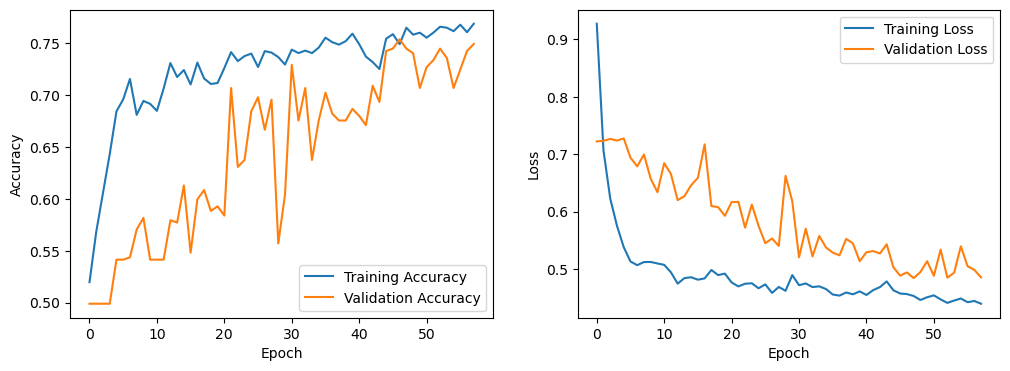

In [10]:
history, model = neural_net_fun.training_process(timesteps, n_classes, n_features, X_train, X_val, Y_train, Y_val, study.best_params, batch_size)
neural_net_fun.plot_learning_curves(history)

## Evaluate the model performance

14/14 [==============================] - 0s 4ms/step
Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1-Score: 0.74


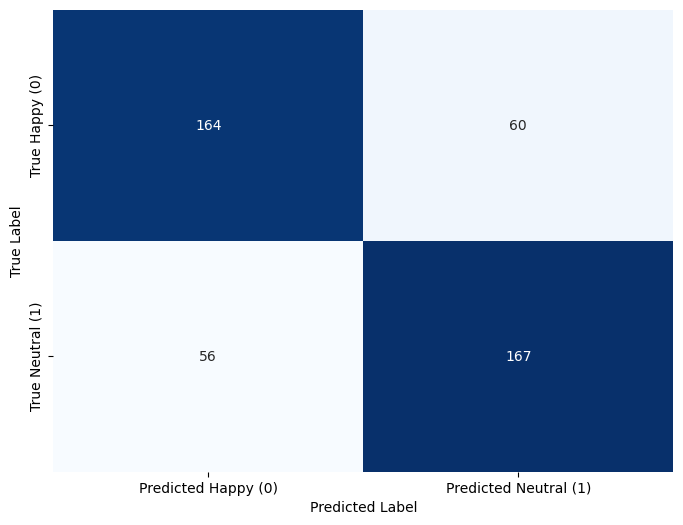

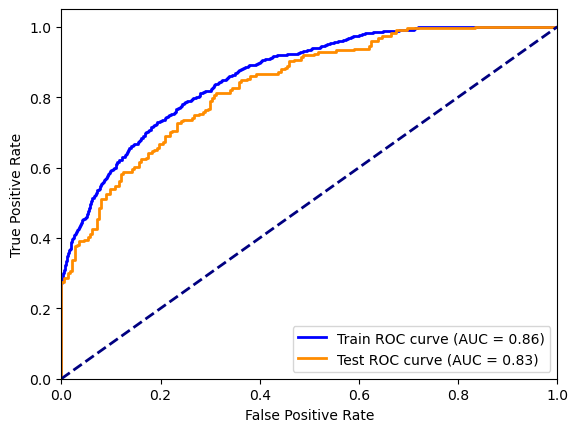

(0.7404921700223713,
 0.7405796127612644,
 0.7404921700223713,
 0.7404765839665168,
 array([[164,  60],
        [ 56, 167]], dtype=int64))

In [11]:
neural_net_fun.evaluate_model_performance(model,  X_train, Y_train, X_test, Y_test)

## Save the models

In [12]:
model.save('model.keras')